This cell is for importing necessary modules.

In [1]:
import heapq  # for minimum spanning tree
import itertools
import os
import pickle  # for saving the data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

This cell is for reading the data file and only looking at the prices for different stocks.

In [2]:
PSE_data = pd.read_csv("daily.csv")
PSE_data["date_id"] = pd.to_datetime(PSE_data["date_id"])
PSE_data = PSE_data.set_index("date_id")
df_filtered = PSE_data.drop(
    columns=[
        col
        for col in PSE_data.columns
        if not (col.startswith("PH_") and col.endswith("_P")) and col != "date_id"
    ]
)
df_filtered = df_filtered.loc["2013-06-25":"2023-09-26"]

This code is for removing the other rows that are not within the last 10 years of the data. I also used the date June 25, 2013 as the start date so that:
- the window size will not cut the amount of days
- when I calculate log returns, I will have exactly 10 years worth of data. 

In [3]:
def has_high_null_percentage(column, null_threshold):
    return column.isnull().sum() > null_threshold


null_percentage_threshold = round(df_filtered.shape[0] * 0.80)

columns_to_drop = []
for col in df_filtered.columns:
    if col == "date_id":
        continue
    if has_high_null_percentage(df_filtered[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)

In [4]:
# turn constant values into nans

for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].mask(
        df_filtered[col] == df_filtered[col].shift()
    )

valid_cols = [col for col in df_filtered.columns if df_filtered[col].notna().sum() > 10]
valid_df = df_filtered[valid_cols]  # valid_cols is a dataframe
df_interpolated = valid_df.interpolate(method="akima")

In [5]:
columns_to_drop = []
for col in df_interpolated.columns:
    if col == "date_id":
        continue
    if has_high_null_percentage(df_interpolated[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_interpolated = df_interpolated.drop(columns=columns_to_drop)

This cell is for calculating log returns.

In [6]:
PSE_log_returns = df_interpolated.copy()
cols_list = PSE_log_returns.columns.difference(["date_id"])
PSE_log_returns[cols_list] = PSE_log_returns[cols_list].replace(0, np.nan)
PSE_log_returns[cols_list] = np.log(
    PSE_log_returns[cols_list] / PSE_log_returns[cols_list].shift(1)\
)

/home/bsdsba2027/dfgo/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


I removed the the row for September 25, 2013, and I filled all the nan values with zero.

In [7]:
PSE_log_returns = PSE_log_returns.loc["2013-09-26":"2023-09-26"]
PSE_log_returns.columns = PSE_log_returns.columns.str.replace(r"_P", "").str.replace(
    r"PH_", ""
)

In [8]:
returns_df = PSE_log_returns.copy()
cols_list = returns_df.columns.to_list()
PSE_log_returns = PSE_log_returns.to_numpy()

In [9]:
# from Prof. Jose's code with a few edits
def returns_to_covar(returns, skips):
    num_col = skips
    test = np.zeros(shape=(num_col, num_col))
    threshold = 0.1
    returns[returns == 0] = np.nan

    for i, j in list(itertools.combinations(np.arange(num_col), 2)):
        row_mask = (~np.isnan(returns[:, i])) & (~np.isnan(returns[:, j]))
        fraction_included = np.sum(row_mask) / len(returns)

        if fraction_included < threshold:
            test[i, j] = 0
        else:
            pi = returns[:, i][row_mask]
            pj = returns[:, j][row_mask]
            test[i, j] = np.sum((pi - np.mean(pi)) * (pj - np.mean(pj))) / len(pi)
            # print(i, j)

    for i in range(num_col):
        row_mask = ~np.isnan(returns[:, i])
        fraction_included = np.sum(row_mask) / len(returns)
        if fraction_included < threshold:
            test[i, i] = np.nan
        else:
            test[i, i] = np.nanstd(returns[:, i]) ** 2

    nan_rows = np.isnan(test).any(axis=1)
    nan_cols = np.isnan(test).any(axis=0)
    drop_indices = np.where(nan_cols)[0]
    keep_rows = ~nan_rows
    keep_cols = ~nan_cols

    arr_cleaned = test[keep_rows][:, keep_cols]
    arr_cleaned = np.where(arr_cleaned, arr_cleaned, arr_cleaned.T)

    return arr_cleaned, drop_indices


# from: https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b
def covar_to_correl(cov_matrix):
    std_devs = np.sqrt(np.diag(cov_matrix))
    outer_v = np.outer(std_devs, std_devs)
    correlation = cov_matrix / outer_v
    correlation[cov_matrix == 0] = 0
    return correlation


# from: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [10]:
skips = len(returns_df.columns)
window = 110
counter = 0

for i in range(len(returns_df.index)):
    returns = PSE_log_returns[i : i + window]
    returns = np.array(returns, dtype=np.float64)

    # this is to get the covar matrix
    covar_matrix, drop_indices = returns_to_covar(returns, skips)
    counter += 1
    covar_matrix = np.array(covar_matrix, dtype=np.float64)
    # print(f"Covar matrix:\n{covar_matrix}")
    
    # droping columns
    win_col_list = cols_list.copy()
    for index in sorted(drop_indices, reverse=True):
        if 0 <= index < len(win_col_list):
            win_col_list.pop(index)

    # print(len(win_col_list), covar_matrix.shape)

    # this is to get the correl matrix
    correl_matrix = covar_to_correl(covar_matrix)
    correl_matrix = np.nan_to_num(correl_matrix, nan=0, posinf=1, neginf=-1)
    correl_matrix = np.clip(correl_matrix, -1, 1)
    correl_matrix = np.array(correl_matrix, dtype=np.float64)

    # this is to get the distance matrix
    distance_matrix = 1 - np.square(correl_matrix)
    distance_matrix = np.array(distance_matrix, dtype=np.float64)

    # this is to save it in a pickle file
    tables = {
        "stock names": win_col_list,
        "PSE log returns": returns,
        "covariance matrix": covar_matrix,
        "correlation matrix": correl_matrix,
        "distance matrix": distance_matrix,
    }

    folder_path = "matrices"
    name = returns_df.index[counter - 1]
    file_path = os.path.join(folder_path, f"{window} {name}.pickl")

    pd.to_pickle(tables, file_path)

193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
193 (193, 193)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
194 (194, 194)
195 (195, 195)
195 (195, 195)
195 (195, 195)
195 (195, 195)
195 (195, 195)
195 (195, 195)
195 (195, 

/tmp/ipykernel_3877/2106991737.py:44: RuntimeWarning: invalid value encountered in divide
  correlation = cov_matrix / outer_v


63 (63, 63)
60 (60, 60)
57 (57, 57)
52 (52, 52)
50 (50, 50)
47 (47, 47)
41 (41, 41)
34 (34, 34)
24 (24, 24)


In [17]:
filepath = "matrices/110 2017-08-25 00:00:00.pickl"
with open(filepath, "rb") as f:
    file = pickle.load(f)
file

{'stock names': ['ASA',
  'ABS',
  'AGN',
  'APC',
  'CHP',
  'CEU',
  'CIR',
  'CAA',
  'EEQ',
  'FEU',
  'GMA',
  'GLD',
  'HCM',
  'IRE',
  'LIB',
  'MAN',
  'FIL',
  'PHTC',
  'PHNX',
  'SBS',
  'ROX',
  'SHL',
  'STI',
  'WPI',
  'VMC',
  'GTC',
  'TSI',
  'LTD',
  'PHCP',
  'MMI',
  'CIP',
  'CAC',
  'CLG',
  'MVY',
  'MAC',
  'PHPC',
  'MRA',
  'ABG',
  'EAG',
  'HI',
  'MWI',
  'PHHN',
  'MKA',
  'AP',
  'TAO',
  'ALS',
  'PHED',
  'FGC',
  'FPA',
  'BNH',
  'MHA',
  'SPC',
  'SDP',
  'IMI',
  'ACN',
  'COI',
  'BKI',
  'COL',
  'CIL',
  'AGF',
  'JOH',
  'FED',
  'LMA',
  'PHLD',
  'PHTA',
  'MFI',
  'CSH',
  'PHAC',
  'PHSE',
  'PHDB',
  'RPA',
  'SPA',
  'DTO',
  'ECP',
  'GLA',
  'CSC',
  'MEI',
  'PHSC',
  'PHUR',
  'RRH',
  'BOG',
  'TAR',
  'CPF',
  'DNL',
  'RFM',
  'SUG',
  'PHFA',
  'CIC',
  'UNR',
  'VTC',
  'MWC',
  'MPI',
  'AVE',
  'AGI',
  'DMC',
  'JGS',
  'SMA',
  'PHIL',
  'SNV',
  'SSI',
  'WLC',
  'RBI',
  'PHEC',
  'FNI',
  'AJO',
  'NIK',
  'NI',
  'OPR',


### Test

In [12]:
skips = len(returns_df.columns)
window = 110
counter = 0
i = 2400

win_col_list = cols_list
returns = PSE_log_returns[i : i + window]
returns = np.array(returns, dtype=np.float64)
print(f"Returns matrix:\n{returns}")

# this is to get the covar matrix
covar_matrix, drop_indices = returns_to_covar(returns, skips)
counter += 1
covar_matrix = np.array(covar_matrix, dtype=np.float64)
print(f"Covar matrix:\n{covar_matrix}")

# droping columns
for index in sorted(drop_indices, reverse=True):
    if 0 <= index < len(win_col_list):
        win_col_list.pop(index)

# this is to get the correl matrix
correl_matrix = covar_to_correl(covar_matrix)
correl_matrix = np.nan_to_num(correl_matrix, nan=0, posinf=1, neginf=-1)
correl_matrix = np.clip(correl_matrix, -1, 1)
correl_matrix = np.array(correl_matrix, dtype=np.float64)
print(f"Correl matrix:\n{correl_matrix}")

# this is to get the distance matrix
distance_matrix = 1 - np.square(correl_matrix)
distance_matrix = np.array(distance_matrix, dtype=np.float64)
print(f"Distance matrix:\n{distance_matrix}")

matrices = [covar_matrix, correl_matrix, distance_matrix]
for matrix in matrices:
    if check_symmetric(matrix) == True:
        print("This matrix is symmetrical.")
        # symmetry = np.max(np.abs(matrix - matrix.T))
        # print(f"{symmetry:.100f}")
        # print(counter)
    if check_symmetric(matrix) == False:
        print("This matrix is not symmetrical.")
        symmetry = np.max(np.abs(matrix - matrix.T))
        print(f"{symmetry:.100f}")
        # print(counter)

Returns matrix:
[[ 0.00139305  0.04430279 -0.01597045 ...  0.00064523 -0.00585623
  -0.00359958]
 [ 0.00138242  0.01900195 -0.01529954 ...  0.00048597 -0.00596647
  -0.00275133]
 [ 0.00409748 -0.13353139 -0.03301763 ...  0.00047869 -0.01858129
  -0.00235665]
 ...
 [ 0.04248197  0.13339505 -0.08758256 ...         nan  0.1169737
   0.00576344]
 [ 0.00940516  0.03132265 -0.13353139 ...         nan  0.03719551
   0.00187227]
 [ 0.00459743  0.02566075 -0.01242164 ...         nan  0.03635856
   0.00184756]]
Covar matrix:
[[ 5.30519256e-05  8.10990492e-05 -2.96273002e-05 ... -1.56719662e-05
   2.22776226e-04 -3.35408071e-05]
 [ 8.10990492e-05  7.11614244e-04 -1.50452428e-04 ...  5.06664147e-05
   5.82176721e-04  3.35910610e-05]
 [-2.96273002e-05 -1.50452428e-04  9.26690063e-04 ... -3.98542325e-05
   3.42016731e-05 -9.77138086e-06]
 ...
 [-1.56719662e-05  5.06664147e-05 -3.98542325e-05 ...  2.36650666e-04
   4.06708443e-04  1.46464542e-04]
 [ 2.22776226e-04  5.82176721e-04  3.42016731e-05 ... 

In [13]:
def check_diagonals(matrix, target_value):
    for i in range(min(len(matrix), len(matrix[0]))):
        if matrix[i][i] != target_value:
            print(f"Diagonal has a weird value at index {i, i}: {matrix[i][i]}")

In [14]:
check_diagonals(distance_matrix, 0)

In [15]:
check_diagonals(correl_matrix, 1)

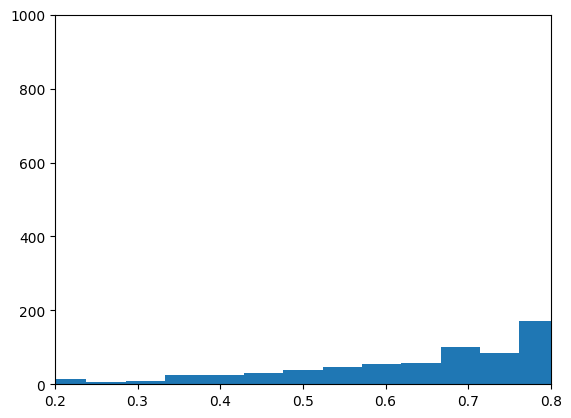

In [16]:
flat = distance_matrix.flatten()
plt.hist(flat, bins=21)
plt.ylim(0, 1000)
plt.xlim(0.2, 0.8)
plt.show()